## Imports

In [1]:
import tensorflow as tf
from gluoncv import data, utils
%matplotlib inline
from matplotlib import pyplot as plt
import h5py
import pickle
import numpy as np
np.random.seed(seed=0)
import pixiedust

from utils import array_iou
from loss import to_iou_coordinates
from ssd import SSD300

Pixiedust database opened successfully


Using TensorFlow backend.


## Constants

In [2]:
DATA_PATH = 'data.h5'
IMAGE_PATH = 'single_data.pickle'
IMG_HEIGHT = 333
IMG_WIDTH = 500

## Utility functions

In [3]:
def to_absolute_coordinates(bb_predictions):
    abs_coordinates = np.empty_like(bb_predictions)
    abs_coordinates[:, :, :2] = bb_predictions[:, :, :2] - bb_predictions[:, :, 2:]/2
    abs_coordinates[:, :, 0] = abs_coordinates[:, :, 0] * IMG_WIDTH
    abs_coordinates[:, :, 1] = abs_coordinates[:, :, 1] * IMG_HEIGHT
    abs_coordinates[:, :, 2:] = bb_predictions[:, :, :2] + bb_predictions[:, :, 2:]/2
    abs_coordinates[:, :, 2] = abs_coordinates[:, :, 2] * IMG_WIDTH
    abs_coordinates[:, :, 3] = abs_coordinates[:, :, 3] * IMG_HEIGHT
    return abs_coordinates

def get_best_prediction_box(abs_predictions, bounding_boxes):
    bb = np.empty_like(abs_predictions)
    bb[:] = bounding_boxes
    ious = array_iou(abs_predictions, bb)
    ind = np.argmax(ious)
    return abs_predictions[ind], ious[ind]

## Load preprocessed and unprocessed data

In [4]:
with h5py.File(DATA_PATH, 'r') as f:
    anchors = f['main']['anchors'][()]
    data = f['main']['image'][()]
    bounding_boxes = f['main']['bounding_box'][()]
    classes = f['main']['class'][()]

with open(IMAGE_PATH, 'rb') as f:
    train_image, train_label = pickle.load(f)
    train_image = train_image.asnumpy()
    single_bounding_box = train_label[:, :4]
    single_class = train_label[:, 4:5]

## Load model

In [5]:
model = SSD300(1)

Instructions for updating:
Use `tf.variables_initializer` instead.


/home/cszsolnai/Projects/ssd/ssd.py:269: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
  self.model = Model(input=vgg16_model.input, output=[localization])


## Train model

In [ ]:
#class_predictions, bb_predictions = model.predict(data)
bb_predictions = model.predict(data)

abs_predictions = to_absolute_coordinates(bb_predictions)

In [ ]:
plt.imshow(train_image)

# Draw correct boundimg box
x1, y1, x2, y2 = single_bounding_box.ravel()
x = np.array([x1, x1, x2, x2, x1])
y = np.array([y1, y2, y2, y1, y1])
plt.plot(x, y, 'ro-', linewidth=1, color='g')

# Draw best estimation
best_prediction, iou = get_best_prediction_box(abs_predictions[0], single_bounding_box)
x1, y1, x2, y2 = best_prediction.ravel()
x = np.array([x1, x1, x2, x2, x1])
y = np.array([y1, y2, y2, y1, y1])
plt.plot(x, y, 'ro-', linewidth=1, color='r')

plt.show()

print(iou)

## Draw anchors

In [ ]:
plt.imshow(train_image)

abs_anchors = to_absolute_coordinates(np.array(model.anchors))
x1, y1, x2, y2 = abs_anchors[0, 0].ravel()
x = np.array([x1, x1, x2, x2, x1])
y = np.array([y1, y2, y2, y1, y1])
plt.plot(x, y, 'ro-', linewidth=1, color='b')

plt.show()

In [6]:
#model.fit(data, y={'confidence': classes, 'localization': bounding_boxes}, epochs=10)
model.fit(data, bounding_boxes, epochs=10)

Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 28ms/step - loss: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00
Epoch 8/10
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00
Epoch 9/10
1/1 [==============================] - 0s 24ms/step - loss: 0.0000e+00
Epoch 10/10
1/1 [==============================] - 0s 23ms/step - loss: 0.0000e+00


In [7]:
#class_predictions, bb_predictions = model.predict(data)
bb_predictions = model.predict(data)

abs_predictions = to_absolute_coordinates(bb_predictions)

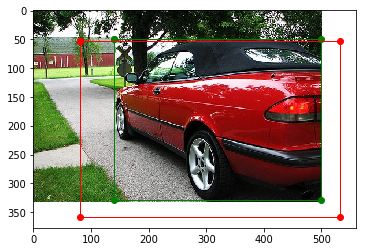

0.70932704


In [8]:
plt.imshow(train_image)

# Draw correct boundimg box
x1, y1, x2, y2 = single_bounding_box.ravel()
x = np.array([x1, x1, x2, x2, x1])
y = np.array([y1, y2, y2, y1, y1])
plt.plot(x, y, 'ro-', linewidth=1, color='g')

# Draw best estimation
best_prediction, iou = get_best_prediction_box(abs_predictions[0], single_bounding_box)
x1, y1, x2, y2 = best_prediction.ravel()
x = np.array([x1, x1, x2, x2, x1])
y = np.array([y1, y2, y2, y1, y1])
plt.plot(x, y, 'ro-', linewidth=1, color='r')

plt.show()

print(iou)